# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from matplotlib import pyplot as plt
import seaborn as sns
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import sqlite3
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/amazon data/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:02<00:00, 2474.71it/s]


In [24]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [25]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 3339.47it/s]


In [27]:
preprocessed_reviews_summary[0]

'thirty bucks'

In [28]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [0]:
final['preprocessed_text'] = preprocessed_reviews
final['preprocessed_summary'] = preprocessed_reviews_summary

In [0]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_text,preprocessed_summary
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...,thirty bucks
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...,flies begone
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...,wow make islickers
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...,great product
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,glad cocker standard poodle puppy loves stuff ...,good stuff


In [0]:
final.to_csv("/content/drive/My Drive/amazon data/final.csv", index=False)

In [0]:
# y = final['Score']
# change = lambda x : 1 if x == 1 else 0
# y = np.array([change(x) for x in y])

In [0]:
# vocab_train = dict()
# for sent in x_train['preprocessed_text'].values:
#     for word in sent.split():
#         if word not in vocab_train.keys():
#             vocab_train[word] = 1
#         else:
#             vocab_train[word] += 1

In [0]:
# import operator
# sorted_dict = sorted(vocab_train.items(), key=lambda x: x[1],reverse = True)         #key = operator.itemgetter(1) to sort a list of tuples on the second key
# print(sorted_dict)

[('not', 3417), ('like', 1368), ('good', 1207), ('great', 1100), ('chips', 984), ('one', 909), ('product', 883), ('would', 866), ('taste', 859), ('food', 855), ('flavor', 808), ('love', 767), ('tea', 763), ('no', 673), ('coffee', 647), ('really', 577), ('get', 571), ('much', 558), ('amazon', 548), ('bag', 522), ('time', 513), ('also', 511), ('buy', 502), ('use', 501), ('find', 488), ('dog', 487), ('best', 481), ('little', 464), ('price', 429), ('well', 426), ('even', 425), ('better', 416), ('tried', 408), ('eat', 406), ('make', 404), ('try', 390), ('could', 357), ('mix', 347), ('first', 345), ('used', 337), ('water', 328), ('found', 322), ('sugar', 322), ('bought', 321), ('made', 308), ('salt', 306), ('flavors', 301), ('sweet', 298), ('recommend', 289), ('brand', 283), ('way', 283), ('store', 282), ('bags', 275), ('since', 273), ('many', 269), ('go', 268), ('delicious', 265), ('order', 264), ('box', 264), ('two', 259), ('free', 255), ('quality', 254), ('think', 252), ('snack', 249), ('

In [0]:
# indices_train = dict()
# ind = 1
# for i in range(len(sorted_dict)):
#     a = sorted_dict[i][0]
#     indices_train[a] = ind
#     ind+=1

In [35]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_text,preprocessed_summary
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...,thirty bucks
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...,flies begone
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...,wow make islickers
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...,great product
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,glad cocker standard poodle puppy loves stuff ...,good stuff


# 1. Splitting data in Train and Test

In [0]:
X = final['preprocessed_text']

In [0]:
Y = final['Score']

In [0]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(X,Y,test_size = 0.3,shuffle = False)

In [40]:
print("Shape of Input  - Train:", x_train.shape)
print("Shape of Output - Train:", y_train.shape)
print("Shape of Input  - Test :", x_test.shape)
print("Shape of Output - Test :", y_test.shape)

Shape of Input  - Train: (3490,)
Shape of Output - Train: (3490,)
Shape of Input  - Test : (1496,)
Shape of Output - Test : (1496,)


# 2. Tokenizing data

In [43]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
tokenize = Tokenizer(num_words=5000)

tokenize.fit_on_texts(x_train)

Xtrain_new = tokenize.texts_to_sequences(x_train)
Xtest_new = tokenize.texts_to_sequences(x_test)

print(Xtrain_new[1])
print(len(Xtrain_new))

[40, 4589, 3767, 3768, 3208, 1116, 1, 614, 4, 7]
3490


In [0]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)


Using TensorFlow backend.


In [47]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(Xtrain_new, maxlen=max_review_length)
X_test = sequence.pad_sequences(Xtest_new, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(3490, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

In [0]:
top_words = 5000

# 3. Architecture 1

In [53]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
a = model.fit(X_train, y_train, nb_epoch=10, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model




Train on 3490 samples, validate on 1496 samples
Epoch 1/10





3490/3490 [==============================] - 52s 15ms/step - loss: 0.4912 - acc: 0.8370 - val_loss: 0.4753 - val_acc: 0.8255
Epoch 2/10
3490/3490 [==============================] - 51s 15ms/step - loss: 0.4350 - acc: 0.8433 - val_loss: 0.4597 - val_acc: 0.8255
Epoch 3/10
3490/3490 [==============================] - 51s 15ms/step - loss: 0.4270 - acc: 0.8433 - val_loss: 0.4434 - val_acc: 0.8255
Epoch 4/10
3490/3490 [==============================] - 53s 15ms/step - loss: 0.4097 - acc: 0.8433 - val_loss: 0.4188 - val_acc: 0.8329
Epoch 5/10
3490/3490 [==============================] - 53s 15ms/step - loss: 0.3687 - acc: 0.8530 - val_loss: 0.4373 - val_acc: 0.8309
Epoch 6/10
3490/3490 [==============================] - 53s 15ms/step - loss: 0.3101 - acc: 0.8696 - val_loss: 0.4298 - val_acc: 0.8416
Epoch 7/10
3490/3490 [==============================] - 53s 15ms/step - loss: 0.2687 - acc: 0.8928 - val_loss: 0.3281 - val_acc:

In [55]:
history_dict = a.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [0]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

Accuracy: 96.05%
##################################
Accuracy: 86.97%


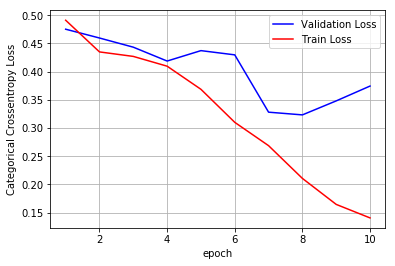

In [56]:
%matplotlib inline 
scores1 = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores1[1]*100))
print("##################################")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))



fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')


x = list(range(1,11))


vy = a.history['val_loss']
ty = a.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:

from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout


# 4. Architecture 2

In [59]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(200))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               186400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 347,401
Trainable params: 347,001
Non-trainable params: 400
______________________________________________________________

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
a = model.fit(X_train, y_train, nb_epoch=10, batch_size=64,validation_data=(X_test, y_test))

Train on 3490 samples, validate on 1496 samples
Epoch 1/10
3490/3490 [==============================] - 106s 31ms/step - loss: 3.3853 - acc: 0.3817 - val_loss: 1.9694 - val_acc: 0.8202
Epoch 2/10
3490/3490 [==============================] - 105s 30ms/step - loss: 0.5424 - acc: 0.7605 - val_loss: 0.5752 - val_acc: 0.8195
Epoch 3/10
3490/3490 [==============================] - 105s 30ms/step - loss: 0.6236 - acc: 0.7954 - val_loss: 0.8474 - val_acc: 0.7219
Epoch 4/10
3490/3490 [==============================] - 107s 31ms/step - loss: 0.4929 - acc: 0.7980 - val_loss: 2.3697 - val_acc: 0.4713
Epoch 5/10
3490/3490 [==============================] - 107s 31ms/step - loss: 0.3519 - acc: 0.8476 - val_loss: 2.2204 - val_acc: 0.2861
Epoch 6/10
3490/3490 [==============================] - 107s 31ms/step - loss: 0.2102 - acc: 0.8307 - val_loss: 1.8947 - val_acc: 0.2841
Epoch 7/10
3490/3490 [==============================] - 108s 31ms/step - loss: 0.2027 - acc: 0.7711 - val_loss: 1.8590 - val_acc: 

Accuracy: 62.21%
##################################
Accuracy: 53.01%


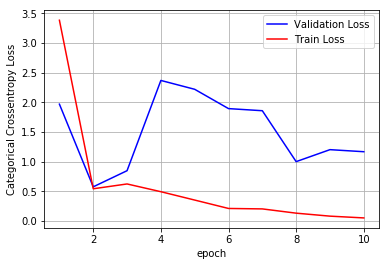

In [62]:
%matplotlib inline 
scores1 = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores1[1]*100))
print("##################################")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))



fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')


x = list(range(1,11))


vy = a.history['val_loss']
ty = a.history['loss']
plt_dynamic(x, vy, ty, ax)

# 5. Architeture 3

In [63]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(200))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               186400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 347,401
Trainable params: 347,001
Non-trainable params: 400
_________________________________________________________________
None


In [64]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
a = model.fit(X_train, y_train, nb_epoch=20, batch_size=64,validation_data=(X_test, y_test))

Train on 3490 samples, validate on 1496 samples
Epoch 1/20
3490/3490 [==============================] - 111s 32ms/step - loss: 3.1595 - acc: 0.4117 - val_loss: 0.8487 - val_acc: 0.8162
Epoch 2/20
3490/3490 [==============================] - 110s 31ms/step - loss: 0.6266 - acc: 0.7587 - val_loss: 1.1484 - val_acc: 0.8222
Epoch 3/20
3490/3490 [==============================] - 110s 31ms/step - loss: 0.5124 - acc: 0.8298 - val_loss: 0.5414 - val_acc: 0.8102
Epoch 4/20
3490/3490 [==============================] - 109s 31ms/step - loss: 0.3594 - acc: 0.8516 - val_loss: 0.7247 - val_acc: 0.7527
Epoch 5/20
3490/3490 [==============================] - 109s 31ms/step - loss: 0.2166 - acc: 0.8390 - val_loss: 0.8427 - val_acc: 0.7620
Epoch 6/20
3490/3490 [==============================] - 110s 31ms/step - loss: 0.1607 - acc: 0.7822 - val_loss: 1.4069 - val_acc: 0.6758
Epoch 7/20
3490/3490 [==============================] - 109s 31ms/step - loss: 0.1063 - acc: 0.7172 - val_loss: 4.3088 - val_acc: 

Accuracy: 17.97%
##################################
Accuracy: 20.92%


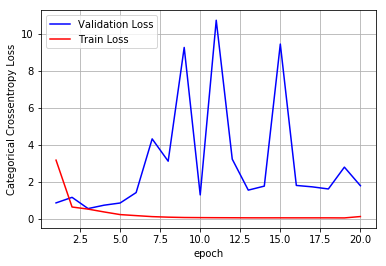

In [65]:
%matplotlib inline 
scores1 = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores1[1]*100))
print("##################################")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))



fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')


x = list(range(1,21))


vy = a.history['val_loss']
ty = a.history['loss']
plt_dynamic(x, vy, ty, ax)

# 6. Architecture 4

In [0]:
# create the model
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(BatchNormalization())
model.add(LSTM(2, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(2))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 600, 64)           320000    
_________________________________________________________________
batch_normalization_11 (Batc (None, 600, 64)           256       
_________________________________________________________________
lstm_20 (LSTM)               (None, 600, 2)            536       
_________________________________________________________________
batch_normalization_12 (Batc (None, 600, 2)            8         
_________________________________________________________________
lstm_21 (LSTM)               (None, 2)                 40        
_________________________________________________________________
dropout_23 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)               

In [0]:
a = model.fit(X_train, y_train, epochs = 15, batch_size = 64, verbose=1,validation_data=(X_test, y_test))

Train on 3490 samples, validate on 1496 samples
Epoch 1/15
3490/3490 [==============================] - 60s 17ms/step - loss: 0.6203 - acc: 0.8246 - val_loss: 0.5959 - val_acc: 0.8255
Epoch 2/15
3490/3490 [==============================] - 48s 14ms/step - loss: 0.5614 - acc: 0.8441 - val_loss: 0.5569 - val_acc: 0.8262
Epoch 3/15
3490/3490 [==============================] - 48s 14ms/step - loss: 0.5224 - acc: 0.8507 - val_loss: 0.5267 - val_acc: 0.8275
Epoch 4/15
3490/3490 [==============================] - 47s 14ms/step - loss: 0.4628 - acc: 0.8582 - val_loss: 0.4804 - val_acc: 0.8282
Epoch 5/15
3490/3490 [==============================] - 47s 13ms/step - loss: 0.3996 - acc: 0.8593 - val_loss: 0.4396 - val_acc: 0.8255
Epoch 6/15
3490/3490 [==============================] - 49s 14ms/step - loss: 0.3645 - acc: 0.8716 - val_loss: 0.4173 - val_acc: 0.8249
Epoch 7/15
3490/3490 [==============================] - 48s 14ms/step - loss: 0.3349 - acc: 0.9080 - val_loss: 0.3997 - val_acc: 0.8255


Accuracy: 97.97%
##################################
Accuracy: 86.16%


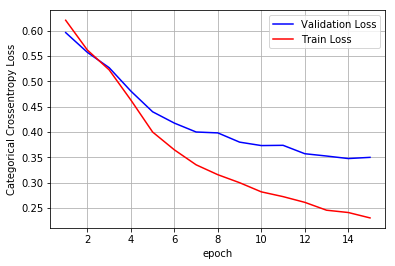

In [0]:
%matplotlib inline 
scores1 = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores1[1]*100))
print("##################################")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))



fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')


x = list(range(1,16))


vy = a.history['val_loss']
ty = a.history['loss']
plt_dynamic(x, vy, ty, ax)

# 7. Architecture 5

In [0]:
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(10,return_sequences=True,dropout=0.5,recurrent_dropout=0.5))
model.add(LSTM(10,dropout=0.5,recurrent_dropout=0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 600, 64)           320000    
_________________________________________________________________
lstm_24 (LSTM)               (None, 600, 10)           3000      
_________________________________________________________________
lstm_25 (LSTM)               (None, 10)                840       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 323,851
Trainable params: 323,851
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
a = model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose=1,validation_data=(X_test, y_test))

Train on 3490 samples, validate on 1496 samples
Epoch 1/5
3490/3490 [==============================] - 78s 22ms/step - loss: 0.5935 - acc: 0.8244 - val_loss: 0.4455 - val_acc: 0.8255
Epoch 2/5
3490/3490 [==============================] - 69s 20ms/step - loss: 0.4028 - acc: 0.8441 - val_loss: 0.3656 - val_acc: 0.8322
Epoch 3/5
3490/3490 [==============================] - 69s 20ms/step - loss: 0.2689 - acc: 0.8997 - val_loss: 0.2683 - val_acc: 0.9011
Epoch 4/5
3490/3490 [==============================] - 69s 20ms/step - loss: 0.1690 - acc: 0.9570 - val_loss: 0.2606 - val_acc: 0.9124
Epoch 5/5
3490/3490 [==============================] - 69s 20ms/step - loss: 0.1182 - acc: 0.9725 - val_loss: 0.2709 - val_acc: 0.9151


Accuracy: 98.88%
##################################
Accuracy: 91.51%


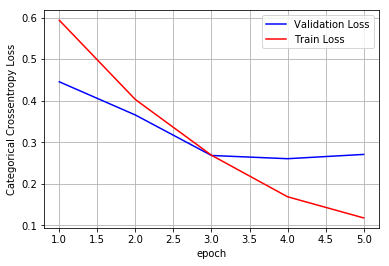

In [0]:
%matplotlib inline 
scores1 = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores1[1]*100))
print("##################################")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))



fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')


x = list(range(1,6))


vy = a.history['val_loss']
ty = a.history['loss']
plt_dynamic(x, vy, ty, ax)

# 8. Architecture 6

In [0]:
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(2,return_sequences=True,dropout=0.5,recurrent_dropout=0.5))
model.add(LSTM(2,dropout=0.5,recurrent_dropout=0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 600, 64)           320000    
_________________________________________________________________
lstm_28 (LSTM)               (None, 600, 2)            536       
_________________________________________________________________
lstm_29 (LSTM)               (None, 2)                 40        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 3         
Total params: 320,579
Trainable params: 320,579
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
a = model.fit(X_train, y_train, epochs = 15, batch_size = 64, verbose=1,validation_data=(X_test, y_test))

Train on 3490 samples, validate on 1496 samples
Epoch 1/15
3490/3490 [==============================] - 73s 21ms/step - loss: 0.6592 - acc: 0.8215 - val_loss: 0.6253 - val_acc: 0.8255
Epoch 2/15
3490/3490 [==============================] - 62s 18ms/step - loss: 0.6027 - acc: 0.8424 - val_loss: 0.5636 - val_acc: 0.8255
Epoch 3/15
3490/3490 [==============================] - 65s 19ms/step - loss: 0.5541 - acc: 0.8433 - val_loss: 0.5082 - val_acc: 0.8255
Epoch 4/15
3490/3490 [==============================] - 67s 19ms/step - loss: 0.5147 - acc: 0.8476 - val_loss: 0.4541 - val_acc: 0.8302
Epoch 5/15
3490/3490 [==============================] - 66s 19ms/step - loss: 0.4662 - acc: 0.8673 - val_loss: 0.3956 - val_acc: 0.8717
Epoch 6/15
3490/3490 [==============================] - 66s 19ms/step - loss: 0.4135 - acc: 0.9011 - val_loss: 0.3442 - val_acc: 0.9004
Epoch 7/15
3490/3490 [==============================] - 66s 19ms/step - loss: 0.3630 - acc: 0.9195 - val_loss: 0.3140 - val_acc: 0.8984


Accuracy: 99.48%
##################################
Accuracy: 89.51%


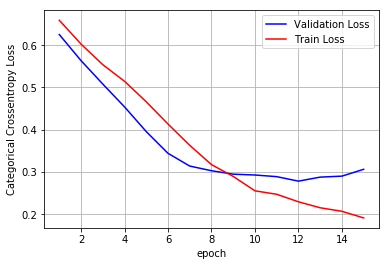

In [0]:
%matplotlib inline 
scores1 = model.evaluate(X_train, y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores1[1]*100))
print("##################################")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))



fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')


x = list(range(1,16))


vy = a.history['val_loss']
ty = a.history['loss']
plt_dynamic(x, vy, ty, ax)

# 9. Conclusion

In [1]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()

x.field_names = ["Model", "Epochs", "Train Accuracy","Test Accuracy"]

x.add_row(["Architecture 1",10, '96.05%','86.97%'])
x.add_row(["Architecture 2",10, '62.21%','53.01%'])
x.add_row(["Architecture 3",20, '17.97%','20.92%'])
x.add_row(["Architecture 4",15, '97.97%','86.16%'])
x.add_row(["Architecture 5",5, '98.88%','91.51%'])
x.add_row(["Architecture 6",15, '99.48%','89.51%'])

print(x)


+----------------+--------+----------------+---------------+
|     Model      | Epochs | Train Accuracy | Test Accuracy |
+----------------+--------+----------------+---------------+
| Architecture 1 |   10   |     96.05%     |     86.97%    |
| Architecture 2 |   10   |     62.21%     |     53.01%    |
| Architecture 3 |   20   |     17.97%     |     20.92%    |
| Architecture 4 |   15   |     97.97%     |     86.16%    |
| Architecture 5 |   5    |     98.88%     |     91.51%    |
| Architecture 6 |   15   |     99.48%     |     89.51%    |
+----------------+--------+----------------+---------------+
